# Histogram of the Dimuon Mass Spectrum

This implements the dimuon analysis, a "hello world" example, using Spark DataFrames.
It is intended as a technology demonstrator for the use Apache Spark and High Energy Physics.

The workload and data:
  - The input is a series of candidate muon events. The input data is from the CERN opendata site.
  - The output of the job is a histogram of the dimuon mass spectrum where several peaks can be identified corresponding to well-know particles and resonances.

Implementations: 
  1. UDF: an implementation with PySpark 3.3-SNAPSHOT, showcasing the newly introduced mapInArrow operator for UDF (see [SPARK-37227](https://issues.apache.org/jira/browse/SPARK-37227)). In addition this uses the Python libraries awkward array and vector.
  2. DataFrame only: a second implementation is provided for reference, that uses only the Spark DataFrame API (no UDF).
  3. SQL: Same as (2), using Spark SQL for DataFrame operations

References:   
  the computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboraiton linked there. For reference, another and different version of this computation using Apache Spark for scaling is at https://swan-gallery.web.cern.ch/notebooks/apache_spark1/NanoAODDimuonAnalysis-PyRDF-Spark.html

Simplistic, and not entirely accurate, notes for those wanting additional hints about the physics behind this computation:
  - The dataset being analyzied contains candidate events at LHC (CMS experiment) with high energy mouns
  - The main idea behind this is that the mouns, which are easily detected at LHC experiments, allow to reconstruct the events where foundamental particles that are more difficult to observe where generated
  - We look here at events where 2 muons are detected, having opposite charge (the total charge of the dimuon system is 0)
  - You need to look up a few formulas of special relativity to understand the data
  - The momentum of high energy particles needs to be treated as a [4-vector](https://en.wikipedia.org/wiki/Four-vector)
  - Momentum data in this dataset is stored in special coordinates [pt, phi, eta, m](https://en.wikipedia.org/wiki/Pseudorapidity)
  - The [invariant mass](https://en.wikipedia.org/wiki/Invariant_mass) of the dimuon system is a key signature of the process/particles that generated them
  - The whole exercice is based on collecting enough data to build up statistical evidence, we need to examine many events and examine the spectrum for peaks and resonances.
  - The final histograms has various peaks corresponding to known particles, for exampe the peak at 91 GeV is corresponds to the [Z boson](https://en.wikipedia.org/wiki/W_and_Z_bosons)
  

Author and contact: Luca.Canali@cern.ch, in collaboration with Jim Pivarski  
January, 2022

## Dataset preparation
This steps takes the CERN openadata dataset and prepares it.  
The preparation is a conversion from the ROOT data format (a data format used in High Energy Physics) to Apache Parquet.  
This is done using Laurelin, an open source library. Laurelin at the time of this writing could only work with Spark 2.x  

```
# Use laurelin to convert root to parquet format
# laurelin 1.1.1 does not work with Spark 3.x, we will use Spark 2.4
# Note Spark 2.4.8 does not work with Python 3.8, use earlier Python versions for this part

# I have use spark-shell to run the conversion, it can be done with pyspark too.

spark-shell --master yarn --num-executors 4 --executor-memory 32g --executor-cores 8 --driver-memory 8g --packages edu.vanderbilt.accre:laurelin:1.1.1

// val fs = org.apache.hadoop.fs.FileSystem.get(sc.hadoopConfiguration)

val fullPathUri = java.net.URI.create("root://eospublic.cern.ch/")
val fs = org.apache.hadoop.fs.FileSystem.get(fullPathUri,sc.hadoopConfiguration).asInstanceOf[ch.cern.eos.XRootDFileSystem]

val dirListing = fs.listFiles(new org.apache.hadoop.fs.Path("root://eospublic.cern.ch/eos/root-eos/benchmark/CMSOpenDataDimuon"), false)

import scala.collection.mutable.ListBuffer
val rootFiles = new ListBuffer[String]()

while (dirListing.hasNext) {
  val filePath = dirListing.next.getPath.toString
  if (filePath matches("^.+.root$")) {
    rootFiles += filePath
  }
}

val files=List("root://eospublic.cern.ch/eos/root-eos/benchmark/CMSOpenDataDimuon/Run2012BC_DoubleMuParked_Muons.root", "root://eospublic.cern.ch/eos/root-eos/benchmark/CMSOpenDataDimuon/Run2012BC_DoubleMuParked_Muons_1.root")

val df=spark.read.format("root").option("tree", "Events").load(files)

df.printSchema()

df.write.mode("overwrite").parquet("hdfs:/PATH_HERE/CMSOpenDataDimuon_large.parquet")

// note files are post-processed to reduce the number of partitions:

val df = spark.read.parquet("CMSOpenDataDimuon_large.parquet")
df.coalesce(64).write.parquet("CMSOpenDataDimuon_large_compacted.parquet")
```

## Dimuon mass spectrum calculation with Spark UDF mapInArrow

In [ ]:
import findspark
findspark.init("/home/luca/Spark/spark-3.3.0-SNAPSHOT-bin-spark_21220128")

# custom Python if needed
import os
os.environ['PYSPARK_PYTHON']="/afs/cern.ch/work/c/canali/public/anaconda202111/bin/python"

from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("dimuon mass")  \
        .master("yarn") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "32g") \
        .config("spark.executor.cores", 10) \
        .config("spark.executor.instances", 20) \
        .config("spark.dynamicAllocation.enabled", "false") \
        .getOrCreate()

In [11]:
# Read data with the muon candidate events

path = "/user/canali/"

df_muons = spark.read.parquet(path + "CMSOpenDataDimuon_large_compacted.parquet")

df_muons.printSchema()

print(f"Number of events: {df_muons.count()}")

root
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)



Number of events: 6461743365


In [12]:
# Apply the filters to select:
#    events with 2 muons
#    the 2 muons have different charge

df_muons = df_muons.filter("nMuon==2").filter("Muon_charge[0] != Muon_charge[1]")

# add the column Dimuon_mass to the DataFrame
# it will be used as output column, to work around the limitation that 
# mapInArrow needs to have the same input and output schema.
df_muons = df_muons.selectExpr("Muon_pt", "Muon_eta","Muon_phi", "Muon_mass", "float(0.0) as Dimuon_mass")

# print(f"Number of events after filter selection: {df_muons.count()}")

In [13]:
df_muons.show(5, False)

+----------------------+-------------------------+------------------------+------------------------+-----------+
|Muon_pt               |Muon_eta                 |Muon_phi                |Muon_mass               |Dimuon_mass|
+----------------------+-------------------------+------------------------+------------------------+-----------+
|[3.1650229, 23.309658]|[-1.6183126, 0.7944226]  |[2.676519, 0.049567416] |[0.10565837, 0.10565837]|0.0        |
|[27.789013, 24.68604] |[-0.592435, 1.7362367]   |[0.22961026, -3.0413804]|[0.10565837, 0.10565837]|0.0        |
|[38.28369, 42.973568] |[-1.7235428, -0.8581355] |[-0.4757328, 2.8505635] |[0.10565837, 0.10565837]|0.0        |
|[15.295548, 21.867908]|[-0.040359497, 0.9803371]|[0.364363, -0.18402384] |[0.10565837, 0.10565837]|0.0        |
|[11.639331, 15.122628]|[2.0050888, 0.5120664]   |[1.3973179, 1.2874984]  |[0.10565837, 0.10565837]|0.0        |
+----------------------+-------------------------+------------------------+---------------------

In [14]:
# this requires pip install awkward and pip install vector
import awkward as ak
import vector

# This is where the dimuon mass is computed
# the candidate muon events and summed as 4-vectors in the Pt, eta, phi, m space
# and the invarian mass is computed
# we use awkward arrray and vector libraries, serializing directly with arrow
def UDF_dimuonmass(iterator):
    vector.register_awkward()
    for batch in iterator:
        chunk = ak.from_arrow(batch)
        muons = ak.zip({"pt": chunk.Muon_pt, "eta": chunk.Muon_eta, "phi": chunk.Muon_phi, "mass": chunk.Muon_mass}, with_name="Momentum4D")
        mu0 = muons[:, 0]
        mu1 = muons[:, 1]
        dimuon_mass = (mu0 + mu1).mass
        out = ak.zip({"Muon_pt": chunk.Muon_pt, "Muon_eta": chunk.Muon_eta, "Muon_phi": chunk.Muon_phi, "Muon_mass": chunk.Muon_mass, "Dimuon_mass": dimuon_mass }, depth_limit=1)
        # out = ak.zip({"Muon_pt": None, "Muon_eta": None, "Muon_phi": None, "Muon_mass": None, "Dimoun_mass": dimuon_mass }, depth_limit=1)
        yield from ak.to_arrow_table(out).to_batches()

In [15]:
# apply the UDF with arrow to compute the dimuon mass spectrum

df_with_dimuonmass = df_muons.mapInArrow(UDF_dimuonmass, df_muons.schema)

In [16]:
df_with_dimuonmass.printSchema()

# small sample of the computation
df_with_dimuonmass.show(5, False)


root
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Dimuon_mass: float (nullable = false)



+----------------------+-------------------------+------------------------+------------------------+-----------+
|Muon_pt               |Muon_eta                 |Muon_phi                |Muon_mass               |Dimuon_mass|
+----------------------+-------------------------+------------------------+------------------------+-----------+
|[3.1650229, 23.309658]|[-1.6183126, 0.7944226]  |[2.676519, 0.049567416] |[0.10565837, 0.10565837]|30.96415   |
|[27.789013, 24.68604] |[-0.592435, 1.7362367]   |[0.22961026, -3.0413804]|[0.10565837, 0.10565837]|92.02572   |
|[38.28369, 42.973568] |[-1.7235428, -0.8581355] |[-0.4757328, 2.8505635] |[0.10565837, 0.10565837]|88.51816   |
|[15.295548, 21.867908]|[-0.040359497, 0.9803371]|[0.364363, -0.18402384] |[0.10565837, 0.10565837]|21.861824  |
|[11.639331, 15.122628]|[2.0050888, 0.5120664]   |[1.3973179, 1.2874984]  |[0.10565837, 0.10565837]|21.749933  |
+----------------------+-------------------------+------------------------+---------------------

In [17]:
# compute the histogram

min_val = 0.25
max_val = 300
num_bins = 30000
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_with_dimuonmass
        .selectExpr(f"width_bucket(Dimuon_mass, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1) * {step},2) as value", "count as N_events")


In [18]:
%%time

# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver.

histogram_data_pandas=histogram_data.toPandas()

CPU times: user 1.14 s, sys: 312 ms, total: 1.45 s
Wall time: 5min 14s


In [19]:
n = histogram_data_pandas.count()
n["value"]

27366

## Histogram plotting
Histogram of the dimuon mass spectrum where several peaks can be identified corresponding to well-know particles and resonances

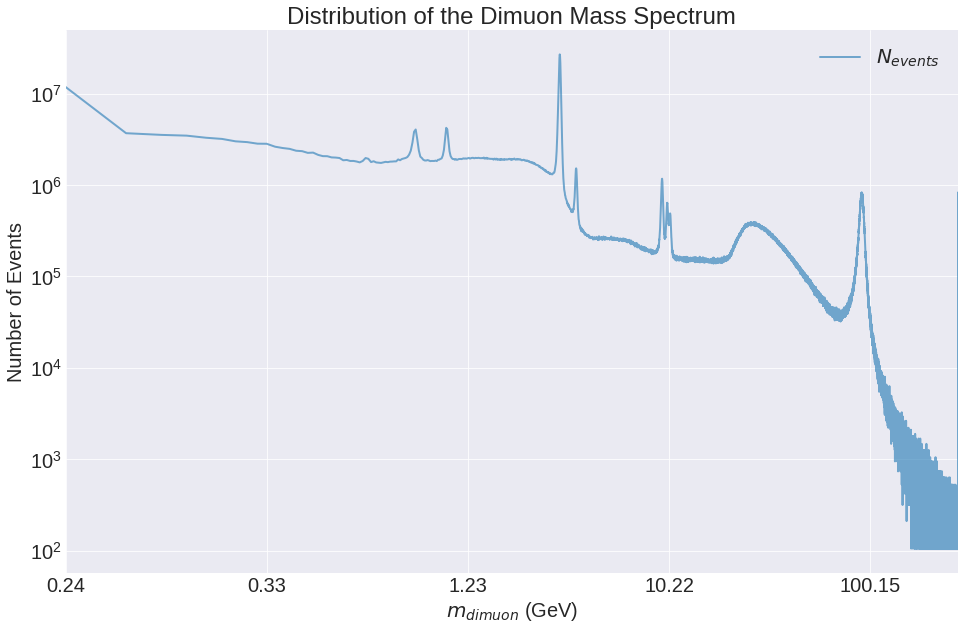

In [20]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [16,10]})

# histogram_data_pandas is a pandas dataframe containing the bins value and counts foreach bin
# the plot is in log-log axis to better show the peaks
ax = histogram_data_pandas.plot(x='value', y='N_events', kind='line', label='$N_{events}$', loglog=True,
                                alpha=0.6, linewidth=2.0, xlim=[1, n["value"]] )

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

plt.show()

------

## Computation of the dimuon spectrum using only Spark DataFrame functions (no UDF)
The following performs the same dimuon mass spectrum calculation using only Spark DataFrame functions. 

In [21]:
# Read data with the muon candidate events
# and apply the filters
# this is the same code as what was used earlier in Dimuon mass spectrum calculation with Spark UDF mapInArrow 

path = "/user/canali/"

df_muons = spark.read.parquet(path + "CMSOpenDataDimuon_large_compacted.parquet")

df_muons = df_muons.filter("nMuon==2").filter("Muon_charge[0] != Muon_charge[1]")


In [22]:
# sum the 4-vectors for the 2 mouns
# convert the 4-vector from pt,eta,phi,m to to px,py,pz,E
# as this will simplify the computation of the mass in the next step
df_dimuon = df_muons.selectExpr(
    "Muon_pt[0] * cos(Muon_phi[0]) + Muon_pt[1] * cos(Muon_phi[1]) px",
    "Muon_pt[0] * sin(Muon_phi[0]) + Muon_pt[1] * sin(Muon_phi[1]) py",
    "Muon_pt[0] * sinh(Muon_eta[0]) + Muon_pt[1] * sinh(Muon_eta[1]) pz",
    "Muon_pt[0] * cosh(Muon_eta[0]) + Muon_pt[1] * cosh(Muon_eta[1]) E"
)

# compute the mass from the px,py,pz,E components of the 4-vector
df_with_dimuonmass = df_dimuon.selectExpr("sqrt(E*E - (px*px + py*py + pz*pz) ) as Dimuon_mass")


In [23]:
# compute the histogram
# this is the same code as what was used earlier in Dimuon mass spectrum calculation with Spark UDF mapInArrow 

min_val = 0.25
max_val = 300
num_bins = 30000
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_with_dimuonmass
        .selectExpr(f"width_bucket(Dimuon_mass, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1) * {step},2) as value", "count as N_events")

In [24]:
%%time

# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver.

histogram_data_pandas=histogram_data.toPandas()

CPU times: user 597 ms, sys: 105 ms, total: 702 ms
Wall time: 1min 39s


In [25]:
n = histogram_data_pandas.count()
n["value"]

27367

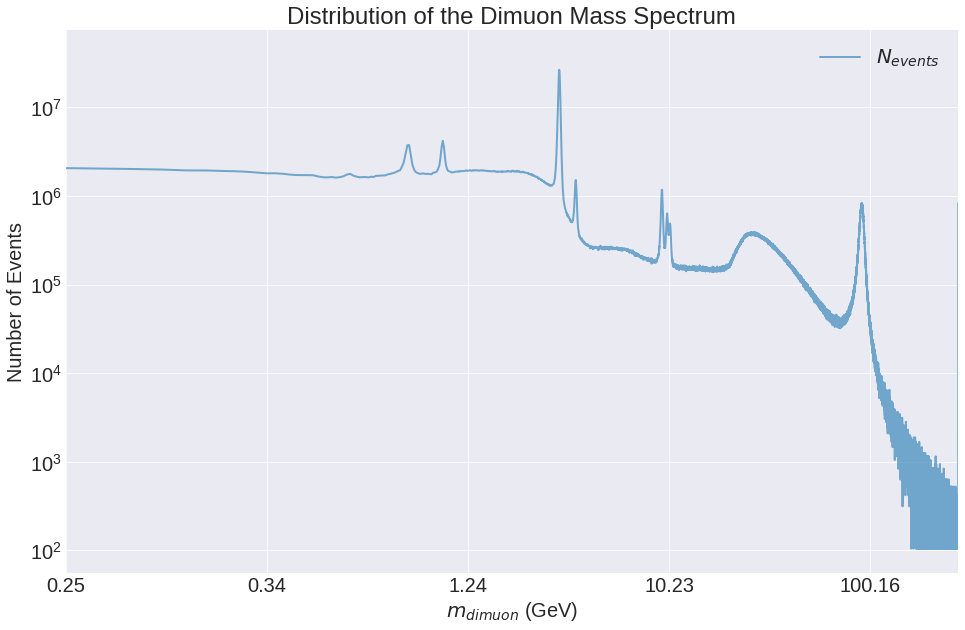

In [26]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [16,10]})

# histogram_data_pandas is a pandas dataframe containing the bins value and counts foreach bin
# the plot is in log-log axis to better show the peaks
ax = histogram_data_pandas.plot(x='value', y='N_events', kind='line', label='$N_{events}$', loglog=True,
                                alpha=0.6, linewidth=2.0, xlim=[1, n["value"]] )

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

plt.show()

# Spark SQL
The computation is done with DataFrame operations only, as in the example above.  
The main difference is that Spark SQL is used instead of the declarative API for DataFrames.

In [27]:
# load data and map it to a temporary table
path = "/user/canali/"

spark.read.parquet(path + "CMSOpenDataDimuon_large_compacted.parquet").createOrReplaceTempView("muons")


In [28]:
spark.table("muons").printSchema()

root
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)



In [29]:
# - apply the selection criteria
#    - only 2 muons (dimuon system)
#    - the muons have opposite charge
# - compute the 4-momentum of the dimuon system 
# - compute the mass from the px,py,pz,E components of the 4-vector


spark.sql("""
with dimuons as (
select
    Muon_pt[0] * cos(Muon_phi[0]) + Muon_pt[1] * cos(Muon_phi[1]) px,
    Muon_pt[0] * sin(Muon_phi[0]) + Muon_pt[1] * sin(Muon_phi[1]) py,
    Muon_pt[0] * sinh(Muon_eta[0]) + Muon_pt[1] * sinh(Muon_eta[1]) pz,
    Muon_pt[0] * cosh(Muon_eta[0]) + Muon_pt[1] * cosh(Muon_eta[1]) E
from muons
where
     nMuon = 2 and
     Muon_charge[0] != Muon_charge[1]
)
select 
    sqrt(E*E - (px*px + py*py + pz*pz) ) as Dimuon_mass
from dimuons
""").createOrReplaceTempView("dimuon_mass")

In [30]:
# compute the histogram
# this is the same code as what was used earlier in Dimuon mass spectrum calculation with Spark UDF mapInArrow 

min_val = 0.25
max_val = 300
num_bins = 30000
step = (max_val - min_val) / num_bins


histogram_data = spark.sql(f"""
with hist as (
select 
    width_bucket(Dimuon_mass, {min_val}, {max_val}, {num_bins}) as bucket,
    count(*) as cnt
from dimuon_mass
group by bucket
order by bucket
)
select
    round({min_val} + (bucket - 1) * {step},2) as value,
    cnt as N_events
from hist
""")


In [31]:
%%time

# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver.

histogram_data_pandas=histogram_data.toPandas()

CPU times: user 563 ms, sys: 88.6 ms, total: 652 ms
Wall time: 1min 41s


In [32]:
n = histogram_data_pandas.count()
n["value"]

27367

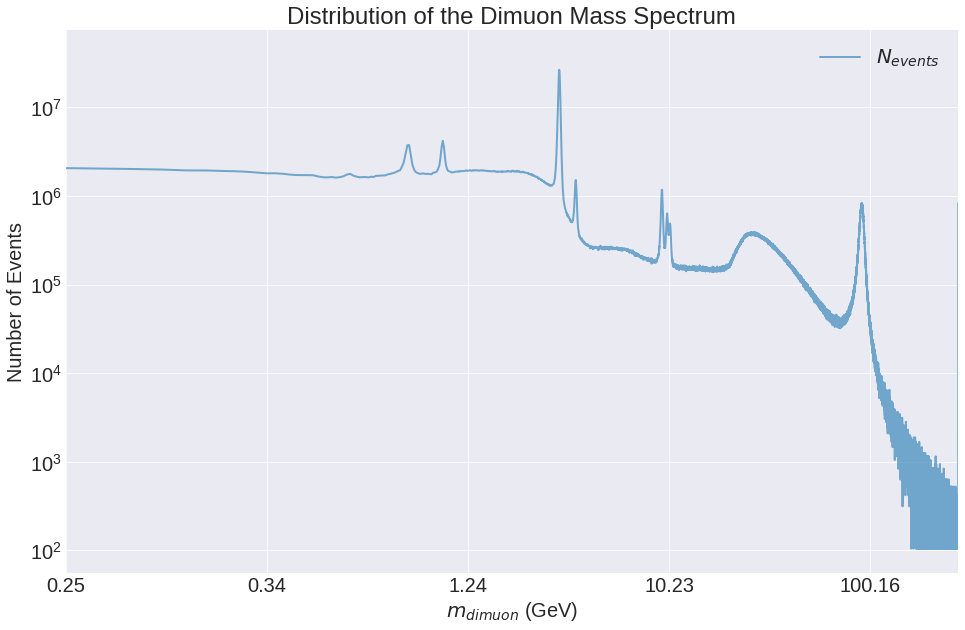

In [33]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [16,10]})

# histogram_data_pandas is a pandas dataframe containing the bins value and counts foreach bin
# the plot is in log-log axis to better show the peaks
ax = histogram_data_pandas.plot(x='value', y='N_events', kind='line', label='$N_{events}$', loglog=True,
                                alpha=0.6, linewidth=2.0, xlim=[1, n["value"]] )

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

plt.show()